# Monte Carlo Methods for Option Pricing

This notebook explores various Monte Carlo simulation techniques for pricing financial derivatives, with a focus on European and barrier options, as well as basket options. It covers:

- Implementation of the Black-Scholes formula for European options.
- Monte Carlo estimators for vanilla and barrier options, including discretization effects and bias analysis.
- Pricing of basket options with correlated assets, and analysis of the impact of correlation and dimension.
- Variance reduction techniques such as control variates (using the geometric mean option) and antithetic variables.
- Visualization and discussion of simulation results, convergence, and confidence intervals.

The notebook is structured with code, explanations, and plots to provide a comprehensive understanding of Monte Carlo methods in quantitative finance.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import ndtri
from sklearn.linear_model import LinearRegression

# Problem 1
a. The UOP option is cheaper than the vanilla put option. Since the payoff is exactly the same except when the price of the stock never goes above H, then the value of the option is at most the value of the vanilla put option and since there are cases where the vanilla put expires in the money so it would have a positive payoff, but when the stock price path exceeds H the vanilla put option still has value but the UOP will have no value. Thus it must be cheaper than the vanilla put option.

<br>
<br>
b. (i.) Biased high is when the value of our estimator exceeds the true price when the number of simulations, n goes to infinity. Unbiased is when the value of our estimator converges to the true price. Biased low is when the value of our estimator is below the true price when n goes to infinity, such as an up and in option.
<br>
(ii.) Biased high is our expected, since the discretization of the steps of time leads to occasions where we can actually cross the barrier but the interval where we may cross may be 54.5 and then 54.7 and we never end up crossing in our simulation, thus giving us a positive payoff but in reality this simulation would have a payoff of 0. This gives us a biased high value since we are not knocking out options that could be knocked out.
<br>
<br>
c. Yes it is consistent with our reasoning.

In [2]:
def black_scholes(S_0, sigma, r, T, K, option_type='call'):
    d1 = (np.log(S_0 / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    gamma = norm.pdf(d1)/(S_0*sigma*np.sqrt(T))

    if option_type == 'call':
        option_price = S_0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S_0 * norm.cdf(-d1)
        delta = norm.cdf(d1) - 1
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    return option_price, d1,d2, delta, gamma


def monte_carlo_euro_option_vectorization(S_0, sigma, r, T, K, n, option_type = 'call'):
    zs = np.random.standard_normal(n)
    W_Ts = np.sqrt(T)*zs
    S_Ts = S_0*np.exp((r-(sigma**2)/2)*T + sigma*W_Ts)
    zeros = np.zeros(n)
    if option_type == 'call':
        V_Ts = np.maximum(zeros, S_Ts-K)
    else:
        V_Ts = np.maximum(zeros, K-S_Ts)
    V_0s = np.exp(-r*T)*np.array(V_Ts)
    option_price = np.mean(V_0s)
    sample_var = np.var(V_0s, ddof = 1)
    CI = [option_price - 1.96*np.sqrt(sample_var/n),option_price + 1.96*np.sqrt(sample_var/n)]
    return option_price, CI, V_0s, S_Ts
 

In [3]:
def compute_est_p(S0, K, sigma, T, r, H, n, m, option_type, option):
    zs = np.random.standard_normal((n,m))
    dt = T/m
    Ws = zs*np.sqrt(dt) 
    S=S0
    S_ts =[]
    for i in range(m):
        S_t = S*np.exp((r-(sigma**2)/2)*dt+Ws[:,i]*sigma)
        S = S_t
        S_ts.append(S_t)
    S_ts = np.array(list(map(list, zip(*S_ts))))
    Ins = np.where(S_ts>H,0,1)*S_ts
    V0s=[]
    for i in range(n):
        if option == 'out':
            if Ins[i].all() == False:
                v0 = 0
            else:
                if option_type == 'call':
                    v0 = np.exp(-r*T)*max(Ins[i][-1]-K,0)
                else:
                    v0 = np.exp(-r*T)*max(K-Ins[i][-1],0)
        else:
            if Ins[i].all() == True:
                v0 = 0
            else:
                if option_type == 'call':
                    v0 = np.exp(-r*T)*max(S_ts[i][-1]-K,0)
                else:
                    v0 = np.exp(-r*T)*max(K-S_ts[i][-1],0)
        V0s.append(v0)
    
    option_price = np.mean(V0s)
    sample_var = np.var(V0s, ddof = 1)
    CI = [option_price - 1.96*np.sqrt(sample_var/n),option_price + 1.96*np.sqrt(sample_var/n)]
    return option_price, CI, S_ts, V0s

In [24]:
m = 63
n= 100000
S0 = 50
K= 60
sigma = .3
T=.25
r= .05
H=55
option_type = 'put'
option='out'
price = compute_est_p(S0, K, sigma, T, r, H, n, m, option_type, option)
mc_vanilla = monte_carlo_euro_option_vectorization(S0, sigma, r, T, K, n, option_type)
bs = black_scholes(S0, sigma, r, T, K, option_type)

In [25]:
print(str(price[0])+' CI is '+str(price[1]))

7.370763957019926 CI is [7.32215679678138, 7.419371117258471]


In [6]:
mc_vanilla[0]

9.779932052764464

In [7]:
bs[0]

9.779249637953527

# Problem 2
a. The graph is provided below. First we create a correlation matrix with ones on the diagonal and rho everywhere else. We then find the cholesky decomposition to solve for a matrix A(A^T) = Corr. We get dxn standard normal random variables, and then multiply A by the Zs in order to get our W(T)s. Using this we calculate our S(T)'s for d different assets. We subtract K and then find the average. We take the max of this value and 0 to get the payoff. We do this for all n of our variables and get n different payoffs. We take the mean to find the expected payoff.
<br>
<br>
b. As rho increases, so does the Expected Price, since there is some drift up and there is higher likelihood that the stocks move together and the expected price is higher. Higher dimensions lead to lower price, because extremes have less effect to move the average price up. If you have 5 dimensions and get 150 in one, while the other 4 have 100, you get a payoff of 110-100 = 10. If there was 100 dimensions, this would only get the average to 100.5 and give a payoff of .5, so you need many more stocks to go up in order to reach the same payoff. This is consistent with our intuition.
<br>
<br>
c.(i.) It is unbiased since there is no discretization and we are sampling from the true distribution of the Stock Price.
<br>
(ii.) The order of convergence is 
\begin{equation}
\frac{1}{\sqrt{n}}
\end{equation}
<br>
(iii.) The order of convergence does not depend on the dimension d. Monte Carlo does not suffer from curse of dimensionality.
<br>
<br>
d. The bound 
\begin{equation}
\frac{-1}{d-1} \le \rho \le 1
\end{equation}
exists because when you have a covariance matrix, the correlation between two variable must not be too negative because there exists then positive correlations with the other values. i.e. if x_1 and x_2 have a negative correlation, and x_2 and x_3 have a negative correlation. Then x_1 and x_3 must have a positive correlation. It can be the case where Corr(x_1,x_2)>0, Corr(x_2,x_3)>0, Corr(x_1,x_3)>0, because they all move up and down together, however it cannot be the case where Corr(x_1,x_2)<0, Corr(x_2,x_3)<0, Corr(x_1,x_3)<0, because if x_1 goes up, then x_2 has to go down, so x_3 has to then go up. but this leads to Corr(x_1,x_3)<0 being wrong. Thus we get a lower bound on the correlation to come up with a valid covariance matrix.
<br>
If d = 3 then rho cannot be -1 since if two stocks have perfect negative correlation then the other stock must have perfect negative correlation with one and then perfect positive correlation with the other, violating the bound.

In [8]:
def basket_call_option(S_0, sigma, r, T, K, n, d, rho, option_type = 'call'):
    
    cov_mat = np.diag(np.ones(d))
    cov_mat = np.where(cov_mat ==0, rho, 1)
    A = np.linalg.cholesky(cov_mat)
    zs = np.random.standard_normal((d,n))
    
    W_Ts = A.dot(zs)*np.sqrt(T)
    
    S_Ts = S_0*np.exp((r-(sigma**2)/2)*T + sigma*W_Ts)
    
    if option_type == 'call':
        V_iTs = S_Ts-K
    
    else:
        V_iTs = K-S_Ts
        
    V_s = np.average(V_iTs, axis= 0) 
    
    V_Ts = np.maximum(V_s, np.zeros(n))
    
    V_0s = np.exp(-r*T)*np.array(V_Ts)
    
    option_price = np.mean(V_0s)
    sample_var = np.var(V_0s, ddof = 1)
    CI = [option_price - 1.96*np.sqrt(sample_var/n),option_price + 1.96*np.sqrt(sample_var/n)]
    
    return option_price, CI, V_0s, S_Ts
 

In [9]:
d = 5
K=100
r=.04
S0 = 100
sigma = .15
T = 1
n=100000
rho = 0
option_type ='call'
basket_call_option(S0, sigma, r, T, K, n, d, rho, option_type = 'call')

(5.0247266292410835,
 [4.991924682435605, 5.057528576046562],
 array([ 0.        , 16.07533913,  0.87580211, ..., 15.69874575,
         1.25804046,  9.93947068]),
 array([[ 75.97530402, 135.7838176 , 100.15181546, ..., 118.25901234,
          88.63162205,  97.58297423],
        [ 78.85825643, 119.55857585,  84.68115991, ..., 124.38907328,
         103.22590264,  99.25249338],
        [102.53870399, 109.19357476,  91.96101439, ..., 107.88625582,
          99.76238206, 120.51528203],
        [103.52651094, 124.34609376, 129.75995957, ..., 103.00947693,
         124.65412137, 131.06381291],
        [ 92.93802464,  94.77486885,  98.00377202, ..., 128.1533002 ,
          90.27288222, 103.31097829]]))

In [10]:
d= 5
lower = -1/(d-1)
rhos_5 = np.arange(lower,1,.001)
prices_5 = []
for rho in rhos_5:
    option_price = basket_call_option(S0, sigma, r, T, K, n, d, rho, option_type = 'call')[0]
    prices_5.append(option_price)

In [11]:
d= 10
lower = -1/(d-1)
rhos_10 = np.arange(lower,1,.001)
prices_10 = []
for rho in rhos_10:
    option_price = basket_call_option(S0, sigma, r, T, K, n, d, rho, option_type = 'call')[0]
    prices_10.append(option_price)

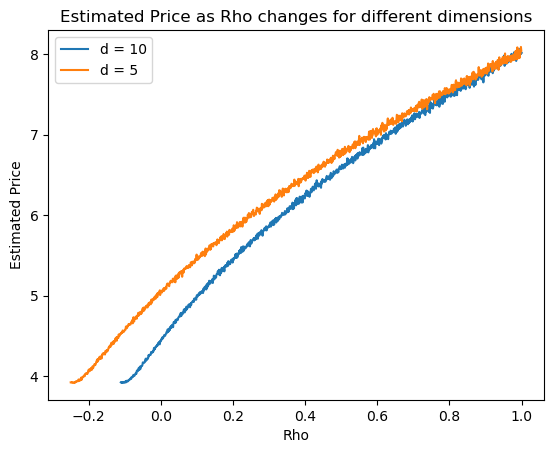

In [12]:
plt.plot(rhos_10 , prices_10, label = 'd = 10')
plt.plot(rhos_5, prices_5, label = 'd = 5')
plt.legend()
plt.xlabel('Rho')
plt.ylabel('Estimated Price')
plt.title('Estimated Price as Rho changes for different dimensions')
plt.show()

# Problem 3

a. Since there is a closed form solution for an option with a payoff that is a geometric mean of a basket, and geometric means and arithmetic means are closely related. This makes a good candidate to use to reduce the variance of our option. The covariance is high between the geometric mean payoff and the arithmetic mean payoff, making it a good option to reduce variance.
<br>
<br>

b.
<br>
<br>
c. We see below that the control variate method gets an incredibly accurate price even with a small n. The black is the confidence interval for the control variate price and the orange line is the control variate price for n from 100 to 10000 simulations. The olive is without the control variate method and the purple line gives the price.

In [134]:
def basket_call_option_geo_mean(S_0, sigma, r, T, K, n, d, rho, option_type = 'call'):
    
    cov_mat = np.diag(np.ones(d))
    cov_mat = np.where(cov_mat ==0, rho, 1)
    A = np.linalg.cholesky(cov_mat)
    zs = np.random.standard_normal((d,n))
    
    W_Ts = A.dot(zs)*np.sqrt(T)
    
    S_Ts = S_0*np.exp((r-(sigma**2)/2)*T + sigma*W_Ts)
    
    if option_type == 'call':
        V_Ts = np.prod(S_Ts, axis = 0)**(1/d) - K
    
    else:
        V_Ts = K-np.prod(S_Ts, axis = 0)**(1/d)   
    
    V_Ts = np.maximum(V_Ts, np.zeros(n))
    
    V_0s = np.exp(-r*T)*np.array(V_Ts)
    
    option_price = np.mean(V_0s)
    sample_var = np.var(V_0s, ddof = 1)
    CI = [option_price - 1.96*np.sqrt(sample_var/n),option_price + 1.96*np.sqrt(sample_var/n)]
    
    return option_price, CI, V_0s, S_Ts



def basket_call_option_control_variate(S_0, sigma, r, T, K, n, d, rho, option_type = 'call'): 
    cov_mat = np.diag(np.ones(d))
    cov_mat = np.where(cov_mat ==0, rho, 1)
    A = np.linalg.cholesky(cov_mat)
    zs = np.random.standard_normal((d,n))
    
    W_Ts = A.dot(zs)*np.sqrt(T)
    
    S_Ts = S_0*np.exp((r-(sigma**2)/2)*T + sigma*W_Ts)
    
    if option_type == 'call':
        V_iTs = S_Ts-K
        V_iTs_geo = np.prod(S_Ts, axis = 0)**(1/d) - K
    
    else:
        V_iTs = K-S_Ts
        V_iTs_geo = K-np.prod(S_Ts, axis = 0)**(1/d)  
        
    V_s = np.average(V_iTs, axis= 0) 
    V_Ts = np.maximum(V_s, np.zeros(n))
    V_0s = np.exp(-r*T)*np.array(V_Ts)
    
    V_Ts_geo = np.maximum(V_iTs_geo, np.zeros(n))
    V_0s_geo = np.exp(-r*T)*np.array(V_Ts_geo)
    
    x_option_price = np.mean(V_0s)
    x_sample_var = np.var(V_0s, ddof = 1)
    CI_x = [x_option_price - 1.96*np.sqrt(x_sample_var/n),x_option_price + 1.96*np.sqrt(x_sample_var/n)]
    
    y_option_price = np.mean(V_0s_geo)
    y_sample_var = np.var(V_0s_geo,ddof=1)
    CI_y = [y_option_price - 1.96*np.sqrt(y_sample_var/n),y_option_price + 1.96*np.sqrt(y_sample_var/n)]
    
    
    cov = sigma*np.sqrt((1+rho*(d-1))/d)
    S= S_0*np.exp((cov**2-sigma**2)*T/2)
    expect_y = black_scholes(S, cov, r, T, K, option_type)[0]
    X= np.stack((V_0s, V_0s_geo),axis = 0)
    cov_xy = np.cov(X)[0][1]
    b = (cov_xy/y_sample_var)
    corr = cov_xy/np.sqrt(y_sample_var*x_sample_var)
    
    
    CV_est = x_option_price - b*(y_option_price - expect_y)
    sample_var_new = x_sample_var*(1-corr**2)
    CI_new = [CV_est - 1.96*np.sqrt(sample_var_new/n),CV_est + 1.96*np.sqrt(sample_var_new/n)]
    
    return x_option_price, CV_est, CI_x, CI_new, V_0s, S_Ts, V_0s_geo


In [158]:
d = 10
K=100
r=.04
S0 = 100
sigma = .15
T = 1
n=10000
rho = 0.3
option_type ='call'
y = basket_call_option_geo_mean(S0, sigma, r, T, K, n, d, rho, option_type)
y[0]

5.434137735707231

In [159]:
cov = sigma*np.sqrt((1+rho*(d-1))/d)
S= S0*np.exp((cov**2-sigma**2)*T/2)
expect_y = black_scholes(S, cov, r, T, K, option_type)[0]
expect_y

5.390558817321569

In [160]:
basket_call_option(S0, sigma, r, T, K, n, d, rho, option_type)[0]

5.977983986957238

In [161]:
basket_call_option_control_variate(S0, sigma, r, T, K, n, d, rho, option_type)[1]

5.865864981363217

In [193]:
d = 10
K=100
r=.04
S0 = 100
sigma = .15
T = 1
rho = 0.3
N= 10000
inc = 100
ns = np.arange(inc,N+inc,inc)
CI_ups = []
CI_downs = []
CI_new_us = []
CI_new_ds = []
no_CVs = []
CVs = []
res = basket_call_option_control_variate(S0, sigma, r, T, K, N, d, rho, option_type)
for n in ns:
    
    xs = res[4][:n]
    ys = res[6][:n]
    
    x_option_price = np.mean(xs)
    x_sample_var = np.var(xs, ddof = 1)
    CI_x = [x_option_price - 1.96*np.sqrt(x_sample_var/n),x_option_price + 1.96*np.sqrt(x_sample_var/n)]
    
    y_option_price = np.mean(ys)
    y_sample_var = np.var(ys,ddof=1)
    CI_y = [y_option_price - 1.96*np.sqrt(y_sample_var/n),y_option_price + 1.96*np.sqrt(y_sample_var/n)]
    
    
    cov = sigma*np.sqrt((1+rho*(d-1))/d)
    S= S0*np.exp((cov**2-sigma**2)*T/2)
    expect_y = black_scholes(S, cov, r, T, K, option_type)[0]
    X= np.stack((xs, ys),axis = 0)
    cov_xy = np.cov(X)[0][1]
    b = (cov_xy/y_sample_var)
    corr = cov_xy/np.sqrt(y_sample_var*x_sample_var)
    
    
    CV_est = x_option_price - b*(y_option_price - expect_y)
    sample_var_new = x_sample_var*(1-corr**2)
    CI_new = [CV_est - 1.96*np.sqrt(sample_var_new/n),CV_est + 1.96*np.sqrt(sample_var_new/n)]
    
    
    CI_up = CI_x[1]
    CI_down = CI_x[0]
    CI_new_u = CI_new[1]
    CI_new_d = CI_new[0]
    no_CV =x_option_price
    CV = CV_est
    CI_ups.append(CI_up)
    CI_downs.append(CI_down)
    CI_new_us.append(CI_new_u)
    CI_new_ds.append(CI_new_d)
    no_CVs.append(no_CV)
    CVs.append(CV)

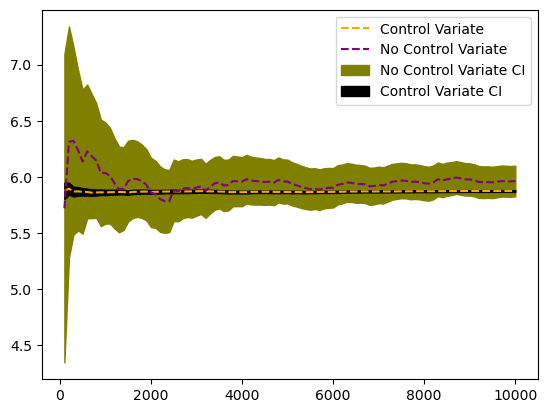

In [194]:
fig, ax = plt.subplots()

ax.plot(ns, CVs,  linestyle ='dashed', color = 'orange', label ='Control Variate')
ax.plot(ns, no_CVs, linestyle ='dashed', color= 'purple', label ='No Control Variate')
ax.fill_between(ns, CI_ups, CI_downs, color = 'olive', label ='No Control Variate CI')
ax.fill_between(ns, CI_new_us, CI_new_ds, color = 'black', label ='Control Variate CI')
ax.legend()
plt.show()

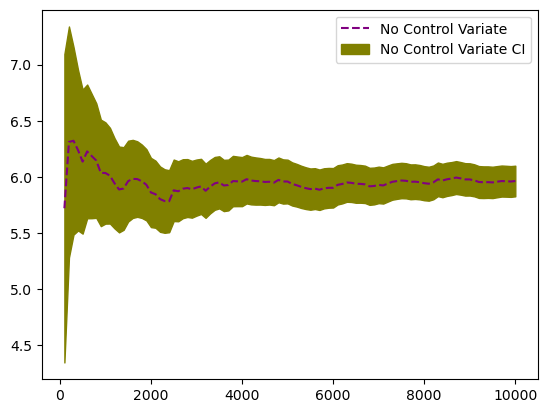

In [197]:
fig, ax = plt.subplots()

#ax.plot(ns, CVs,  linestyle ='dashed', color = 'orange', label ='Control Variate')
ax.plot(ns, no_CVs, linestyle ='dashed', color= 'purple', label ='No Control Variate')
ax.fill_between(ns, CI_ups, CI_downs, color = 'olive', label ='No Control Variate CI')
#ax.fill_between(ns, CI_new_us, CI_new_ds, color = 'black', label ='Control Variate CI')
ax.legend()
plt.show()

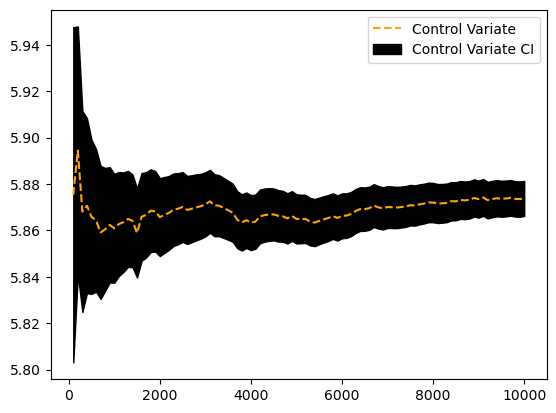

In [198]:
fig, ax = plt.subplots()

ax.plot(ns, CVs,  linestyle ='dashed', color = 'orange', label ='Control Variate')
#ax.plot(ns, no_CVs, linestyle ='dashed', color= 'purple', label ='No Control Variate')
#ax.fill_between(ns, CI_ups, CI_downs, color = 'olive', label ='No Control Variate CI')
ax.fill_between(ns, CI_new_us, CI_new_ds, color = 'black', label ='Control Variate CI')
ax.legend()
plt.show()

# Problem 4
a. Antithetic Variables can be used because for the european call we generate n random variables (z_1,...,z_n). We then can get another n random variables without simulating more by taking the set (-z_1,...,-z_n). Thus getting 2n variables but only simulating n variables.
<br>
<br>
b. When the option is path dependent. We can take the antithetic of the path so for n paths with m steps we can simulate a path with m random variables path 1:(z_1,...,z_m) and then take the antithetic of the path path 2:(-z_1,...,-z_m) and we do this for all n paths to get 2n paths. So in this case each path has an inverse path. and then we do this to get 2n paths.